In [1]:
import os
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from pointnav_vo.config.vo_config.default import get_config as get_vo_config
from pointnav_vo.vo import VOTransformerRegressionGeometricInvarianceEngine

In [2]:
config = get_vo_config('/datasets/home/memmel/PointNav-VO/configs/vo/vo_pointnav_vit.yaml', [])
config.defrost()
config.VO.DATASET.TRAIN = config.VO.DATASET.TRAIN_WITH_NOISE
config.VO.DATASET.EVAL = config.VO.DATASET.EVAL_WITH_NOISE
config.freeze()

In [3]:
engine = VOTransformerRegressionGeometricInvarianceEngine(config=config, run_type='train')
engine._set_up_dataloader(0,1)

2022-03-02 17:30:58,610 Visual Odometry configs:
BASE_TASK_CONFIG_PATH: configs/challenge_pointnav2021.local.rgbd.yaml
CHECKPOINT_FOLDER: {{LOG_DIR}}/checkpoints
DEBUG: True
ENGINE_NAME: vo_transformer_regression_geo_inv_engine
EVAL:
  EVAL_CKPT_PATH: eval_ckpt.pth
  EVAL_WITH_CKPT: True
INFO_DIR: {{LOG_DIR}}/infos
LOG_DIR: train_log/vit/
LOG_FILE: {{LOG_DIR}}/train.log
LOG_INTERVAL: 1
N_GPUS: -1
RESUME_STATE_FILE: resume_train_ckpt.pth
RESUME_TRAIN: False
TASK_CONFIG:
  DATASET:
    CONTENT_SCENES: ['*']
    DATA_PATH: /scratch/memmel/dataset/habitat_datasets/pointnav/gibson/v2/{split}/{split}.json.gz
    SCENES_DIR: /scratch/memmel/dataset/Gibson
    SPLIT: train
    TYPE: PointNav-v1
  ENVIRONMENT:
    ITERATOR_OPTIONS:
      CYCLE: True
      GROUP_BY_SCENE: True
      MAX_SCENE_REPEAT_EPISODES: -1
      MAX_SCENE_REPEAT_STEPS: 10000
      NUM_EPISODE_SAMPLE: -1
      SHUFFLE: False
      STEP_REPETITION_RANGE: 0.2
    MAX_EPISODE_SECONDS: 10000000
    MAX_EPISODE_STEPS: 500
  PYRO

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 1898.52it/s]
2022-03-02 17:30:59,384 ... done. lenght 5435



In [4]:
train_iter = iter(engine.train_loader)
with tqdm(total=0) as pbar:
            
    while True:
        try:
            batch_data = next(train_iter)
        # NOTE RuntimeError: DataLoader timed out after 300 seconds
        except RuntimeError  as re:
            print(re)
            batch_data = next(train_iter)
        except StopIteration:
            break

        (data_types,
        raw_rgb_pairs,
        raw_depth_pairs,
        raw_discretized_depth_pairs,
        raw_top_down_view_pairs,

        actions,
        delta_xs,
        delta_ys,
        delta_zs,
        delta_yaws,
        dz_regress_masks,

        chunk_idxs,
        entry_idxs,
        ) = batch_data
        
        batch_data = batch_data
        
        break


0it [00:02, ?it/s]


In [11]:
ct = 10
depth_ct = torch.cat([torch.cat((pair[:,ct:-ct,ct:-ct,:pair.shape[-1]//2], pair[:,ct:-ct,ct:-ct,pair.shape[-1]//2:]),dim=1).float().to(torch.device('cpu'), non_blocking=True)
                        for pair in raw_depth_pairs], dim=0)

In [12]:
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_grid(imgs_tensor, idx=0, nrow_ncols=(2, 2)):

    fig = plt.figure(figsize=[n*4 for n in nrow_ncols])
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=nrow_ncols,  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, imgs_tensor[idx:idx+np.prod(nrow_ncols)]):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)

    plt.show()

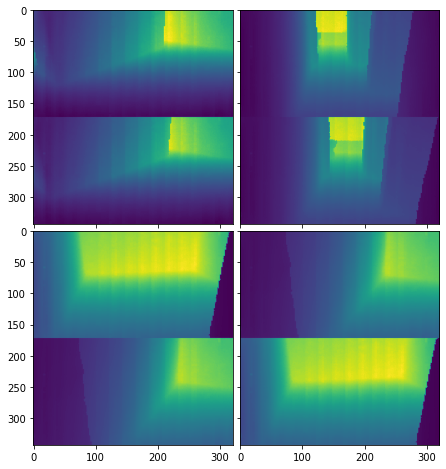

In [13]:
plot_grid(depth_ct)

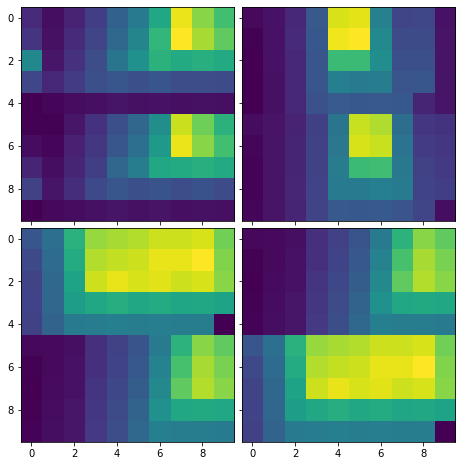

In [14]:
depth_interpolate = torch.nn.functional.interpolate(depth_ct.permute(0,3,1,2), (10,10)).permute(0,2,3,1)
plot_grid(depth_interpolate)

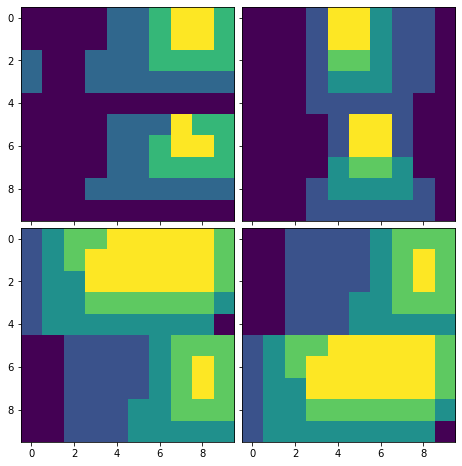

In [15]:
plot_grid(torch.round(depth_interpolate*10))

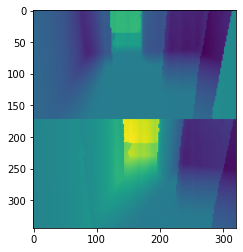

In [16]:
depth_diff = (depth_ct[1] - depth_ct[2]).unsqueeze(0)
plot_grid(depth_diff, nrow_ncols=(1, 1))